In [1]:
!pwd

/content


In [5]:
cd drive

/content/drive


In [6]:
pwd

'/content/drive'

In [ ]:
!unzip /content/T91.zip

Archive:  /content/T91.zip
   creating: T91/
  inflating: T91/tt9.png             
  inflating: T91/tt8.png             
  inflating: T91/tt7.png             
  inflating: T91/tt6.png             
  inflating: T91/tt5.png             
  inflating: T91/tt4.png             
  inflating: T91/tt3.png             
  inflating: T91/tt27.png            
  inflating: T91/tt26.png            
  inflating: T91/tt25.png            
  inflating: T91/tt24.png            
  inflating: T91/tt23.png            
  inflating: T91/tt22.png            
  inflating: T91/tt21.png            
  inflating: T91/tt20.png            
  inflating: T91/tt2.png             
  inflating: T91/tt19.png            
  inflating: T91/tt18.png            
  inflating: T91/tt17.png            
  inflating: T91/tt16.png            
  inflating: T91/tt15.png            
  inflating: T91/tt14.png            
  inflating: T91/tt13.png            
  inflating: T91/tt12.png            
  inflating: T91/tt10.png            
  inf

In [1]:
import os
import cv2
import h5py
import numpy

DATA_PATH = "/content/drive/MyDrive/SRCNN-keras/T91"
TEST_PATH = "/content/drive/MyDrive/SRCNN-keras/Set5/GTmod12"
Random_Crop = 30
Patch_size = 32
label_size = 20
conv_side = 6
scale = 2


def prepare_data(_path):
    names = os.listdir(_path)
    names = sorted(names)
    nums = names.__len__()

    data = numpy.zeros((nums * Random_Crop, 1, Patch_size, Patch_size), dtype=numpy.double)
    label = numpy.zeros((nums * Random_Crop, 1, label_size, label_size), dtype=numpy.double)

    valid_images = 0  # Track valid images

    for i in range(nums):
        name = os.path.join(_path, names[i])
        hr_img = cv2.imread(name, cv2.IMREAD_COLOR)

        # Add check for None
        if hr_img is None:
            print(f"Error: Could not load image {name}. Check the file path or integrity.")
            continue  # Skip this image

        shape = hr_img.shape

        hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
        hr_img = hr_img[:, :, 0]

        # two resize operation to produce training data and labels
        lr_img = cv2.resize(hr_img, (shape[1] // scale, shape[0] // scale))
        lr_img = cv2.resize(lr_img, (shape[1], shape[0]))

        # produce Random_Crop random coordinate to crop training img
        Points_x = numpy.random.randint(0, min(shape[0], shape[1]) - Patch_size, Random_Crop)
        Points_y = numpy.random.randint(0, min(shape[0], shape[1]) - Patch_size, Random_Crop)

        for j in range(Random_Crop):
            lr_patch = lr_img[Points_x[j]: Points_x[j] + Patch_size, Points_y[j]: Points_y[j] + Patch_size]
            hr_patch = hr_img[Points_x[j]: Points_x[j] + Patch_size, Points_y[j]: Points_y[j] + Patch_size]

            lr_patch = lr_patch.astype(float) / 255.
            hr_patch = hr_patch.astype(float) / 255.

            data[valid_images * Random_Crop + j, 0, :, :] = lr_patch
            label[valid_images * Random_Crop + j, 0, :, :] = hr_patch[conv_side: -conv_side, conv_side: -conv_side]

        valid_images += 1

    # Resize arrays to match actual number of valid images
    if valid_images < nums:
        data = data[:valid_images * Random_Crop]
        label = label[:valid_images * Random_Crop]

    return data, label

# BORDER_CUT = 8
BLOCK_STEP = 16
BLOCK_SIZE = 32


def prepare_crop_data(_path):
    names = os.listdir(_path)
    names = sorted(names)
    nums = names.__len__()

    data = []
    label = []

    for i in range(nums):
        # name = _path + names[i]
        name = os.path.join(_path, names[i])
        hr_img = cv2.imread(name, cv2.IMREAD_COLOR)
        hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
        hr_img = hr_img[:, :, 0]
        #hr_img = cv2.imread(name, cv2.IMREAD_COLOR)
        if hr_img is None:
          print(f"Error: Could not load image {name}. Check the file path or integrity.")
          continue  # Skip this image and move to the next one

        shape = hr_img.shape

        # two resize operation to produce training data and labels
        lr_img = cv2.resize(hr_img, (shape[1] // scale, shape[0] // scale))
        lr_img = cv2.resize(lr_img, (shape[1], shape[0]))

        width_num = (shape[0] - (BLOCK_SIZE - BLOCK_STEP) * 2) // BLOCK_STEP
        height_num = (shape[1] - (BLOCK_SIZE - BLOCK_STEP) * 2) // BLOCK_STEP
        for k in range(width_num):
            for j in range(height_num):
                x = k * BLOCK_STEP
                y = j * BLOCK_STEP
                hr_patch = hr_img[x: x + BLOCK_SIZE, y: y + BLOCK_SIZE]
                lr_patch = lr_img[x: x + BLOCK_SIZE, y: y + BLOCK_SIZE]

                lr_patch = lr_patch.astype(float) / 255.
                hr_patch = hr_patch.astype(float) / 255.

                lr = numpy.zeros((1, Patch_size, Patch_size), dtype=numpy.double)
                hr = numpy.zeros((1, label_size, label_size), dtype=numpy.double)

                lr[0, :, :] = lr_patch
                hr[0, :, :] = hr_patch[conv_side: -conv_side, conv_side: -conv_side]

                data.append(lr)
                label.append(hr)

    data = numpy.array(data, dtype=float)
    label = numpy.array(label, dtype=float)
    return data, label


def write_hdf5(data, labels, output_filename):
    """
    This function is used to save image data and its label(s) to hdf5 file.
    output_file.h5,contain data and label
    """

    x = data.astype(numpy.float32)
    y = labels.astype(numpy.float32)

    with h5py.File(output_filename, 'w') as h:
        h.create_dataset('data', data=x, shape=x.shape)
        h.create_dataset('label', data=y, shape=y.shape)
        # h.create_dataset()


def read_training_data(file):
    with h5py.File(file, 'r') as hf:
        data = numpy.array(hf.get('data'))
        label = numpy.array(hf.get('label'))
        train_data = numpy.transpose(data, (0, 2, 3, 1))
        train_label = numpy.transpose(label, (0, 2, 3, 1))
        return train_data, train_label


if __name__ == "__main__":
    data, label = prepare_crop_data(DATA_PATH)
    write_hdf5(data, label, "train.h5")
    data, label = prepare_data(TEST_PATH)
    write_hdf5(data, label, "test.h5")
    # _, _a = read_training_data("train.h5")
    # _, _a = read_training_data("test.h5")


In [2]:
import os

DATA_PATH = "/content/drive/MyDrive/SRCNN-keras/T91"

if not os.path.exists(DATA_PATH):
    print(f"Error: The directory {DATA_PATH} does not exist!")

else:
    files = os.listdir(DATA_PATH)
    print(f"Files in {DATA_PATH}:", files)

    if len(files) == 0:
        print("Error: No images found in the directory!")


Files in /content/drive/MyDrive/SRCNN-keras/T91: ['tt9.png', 'tt8.png', 'tt7.png', 'tt6.png', 'tt5.png', 'tt4.png', 'tt3.png', 'tt27.png', 'tt26.png', 'tt25.png', 'tt24.png', 'tt23.png', 'tt22.png', 'tt21.png', 'tt20.png', 'tt2.png', 'tt19.png', 'tt18.png', 'tt17.png', 'tt16.png', 'tt15.png', 'tt14.png', 'tt13.png', 'tt12.png', 'tt10.png', 'tt1.png', 't9.png', 't8.png', 't7.png', 't66.png', 't65.png', 't64.png', 't63.png', 't62.png', 't61.png', 't60.png', 't6.png', 't59.png', 't58.png', 't57.png', 't56.png', 't55.png', 't54.png', 't53.png', 't52.png', 't51.png', 't50.png', 't5.png', 't49.png', 't48.png', 't47.png', 't46.png', 't45.png', 't44.png', 't43.png', 't42.png', 't40.png', 't4.png', 't39.png', 't38.png', 't37.png', 't36.png', 't35.png', 't34.png', 't33.png', 't32.png', 't31.png', 't30.png', 't3.png', 't29.png', 't28.png', 't27.png', 't26.png', 't25.png', 't24.png', 't23.png', 't22.png', 't21.png', 't20.png', 't2.png', 't19.png', 't18.png', 't17.png', 't16.png', 't15.png', 't14.p

In [55]:
from keras.models import Sequential
from keras.layers import Conv2D, Input, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam
# import prepare_data as pd
import numpy
import math


def psnr(target, ref):
    # assume RGB image
    target_data = numpy.array(target, dtype=float)
    ref_data = numpy.array(ref, dtype=float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(numpy.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)


def model():
    SRCNN = Sequential()
    SRCNN.add(Conv2D(filters=128, kernel_size=(9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(32, 32, 1)))
    SRCNN.add(Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    # SRCNN.add(BatchNormalization())
    SRCNN.add(Conv2D(filters=1, kernel_size=(5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))
    adam = Adam(learning_rate=0.0003)
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    return SRCNN


def predict_model():
    SRCNN = Sequential()
    SRCNN.add(Conv2D(filters=128, kernel_size=(9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))
    SRCNN.add(Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    # SRCNN.add(BatchNormalization())
    SRCNN.add(Conv2D(filters=1, kernel_size=(5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))
    adam = Adam(learning_rate=0.0001)
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    return SRCNN


def train():
    srcnn_model = model()
    print(srcnn_model.summary())
    data, label = read_training_data("train.h5")
    val_data, val_label = read_training_data("test.h5")

    checkpoint = ModelCheckpoint("SRCNN_check.h5", monitor='val_loss', verbose=1, save_best_only=True,
                                 save_weights_only=False, mode='min')
    callbacks_list = [checkpoint]

    srcnn_model.fit(data, label, batch_size=128, validation_data=(val_data, val_label),
                    callbacks=callbacks_list, shuffle=True, epochs=200, verbose=1)
    # srcnn_model.load_weights("/content/drive/MyDrive/SRCNN-keras/m_model_adam_new30.h5")

if __name__ == "__main__":
    train()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_66 (Conv2D)                   │ (None, 24, 24, 128)         │          10,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_67 (Conv2D)                   │ (None, 24, 24, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_68 (Conv2D)                   │ (None, 20, 20, 1)           │           1,601 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,889 (335.50 KB)

 Trainable params: 85,889 (335.50 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/200
 65/117 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0246 - mean_squared_error: 0.0246

KeyboardInterrupt: 

In [41]:
def predict(path,n):
    srcnn_model = predict_model()
    # srcnn_model.load_weights("/content/drive/MyDrive/SRCNN-keras/3051crop_weight_200.h5")
    srcnn_model.load_weights("/content/SRCNN_check.h5")
    IMG_NAME = path
    INPUT_NAME = f"inp{n}.jpg"
    OUTPUT_NAME = f"pre{n}.jpg"

    import cv2
    img = cv2.imread(IMG_NAME, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    shape = img.shape
    Y_img = cv2.resize(img[:, :, 0], (shape[1] // 2, shape[0] // 2), cv2.INTER_CUBIC)
    Y_img = cv2.resize(Y_img, (shape[1], shape[0]), cv2.INTER_CUBIC)
    img[:, :, 0] = Y_img
    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
    cv2.imwrite(INPUT_NAME, img)

    Y = numpy.zeros((1, img.shape[0], img.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = Y_img.astype(float) / 255.
    pre = srcnn_model.predict(Y, batch_size=1) * 255.
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(numpy.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    img[6: -6, 6: -6, 0] = pre[0, :, :, 0]
    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
    cv2.imwrite(OUTPUT_NAME, img)

    # psnr calculation:
    im1 = cv2.imread(IMG_NAME, cv2.IMREAD_COLOR)
    im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2YCrCb)[6: -6, 6: -6, 0]
    im2 = cv2.imread(INPUT_NAME, cv2.IMREAD_COLOR)
    im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2YCrCb)[6: -6, 6: -6, 0]
    im3 = cv2.imread(OUTPUT_NAME, cv2.IMREAD_COLOR)
    im3 = cv2.cvtColor(im3, cv2.COLOR_BGR2YCrCb)[6: -6, 6: -6, 0]

    print("bicubic:")
    print(cv2.PSNR(im1, im2))
    print("SRCNN:")
    print(cv2.PSNR(im1, im3))

In [49]:
path = "/content/drive/MyDrive/SRCNN-keras/baby.png"
predict(path,1)

path = "/content/drive/MyDrive/SRCNN-keras/bird.png"
predict(path,2)

path = "/content/drive/MyDrive/SRCNN-keras/butterfly_GT.bmp"
predict(path,3)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
bicubic:
43.33670453830372
SRCNN:
46.78178260624583
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
bicubic:
41.14902404669586
SRCNN:
45.37411535613497
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 864ms/step
bicubic:
24.696589313104266
SRCNN:
29.924078847684044


In [51]:
def display_comparison_3x3(input_path1, input_path2, input_path3, output_path1, output_path2, output_path3):
    import cv2
    import matplotlib.pyplot as plt
    import numpy as np

    input_img1 = cv2.imread(input_path1)
    input_img2 = cv2.imread(input_path2)
    input_img3 = cv2.imread(input_path3)
    output_img1 = cv2.imread(output_path1)
    output_img2 = cv2.imread(output_path2)
    output_img3 = cv2.imread(output_path3)

    input_img1 = cv2.cvtColor(input_img1, cv2.COLOR_BGR2RGB)
    input_img2 = cv2.cvtColor(input_img2, cv2.COLOR_BGR2RGB)
    input_img3 = cv2.cvtColor(input_img3, cv2.COLOR_BGR2RGB)
    output_img1 = cv2.cvtColor(output_img1, cv2.COLOR_BGR2RGB)
    output_img2 = cv2.cvtColor(output_img2, cv2.COLOR_BGR2RGB)
    output_img3 = cv2.cvtColor(output_img3, cv2.COLOR_BGR2RGB)

    fig, axes = plt.subplots(3, 2, figsize=(8, 12))

    axes[0, 0].imshow(input_img1)
    axes[0, 0].set_title('Input Image 1 (Bicubic)')
    axes[0, 0].axis('off')
    axes[0, 1].imshow(output_img1)
    axes[0, 1].set_title('SRCNN Prediction 1')
    axes[0, 1].axis('off')

    axes[1, 0].imshow(input_img2)
    axes[1, 0].set_title('Input Image 2 (Bicubic)')
    axes[1, 0].axis('off')
    axes[1, 1].imshow(output_img2)
    axes[1, 1].set_title('SRCNN Prediction 2')
    axes[1, 1].axis('off')

    axes[2, 0].imshow(input_img3)
    axes[2, 0].set_title('Input Image 3 (Bicubic)')
    axes[2, 0].axis('off')
    axes[2, 1].imshow(output_img3)
    axes[2, 1].set_title('SRCNN Prediction 3')
    axes[2, 1].axis('off')

    plt.tight_layout()
    plt.show()

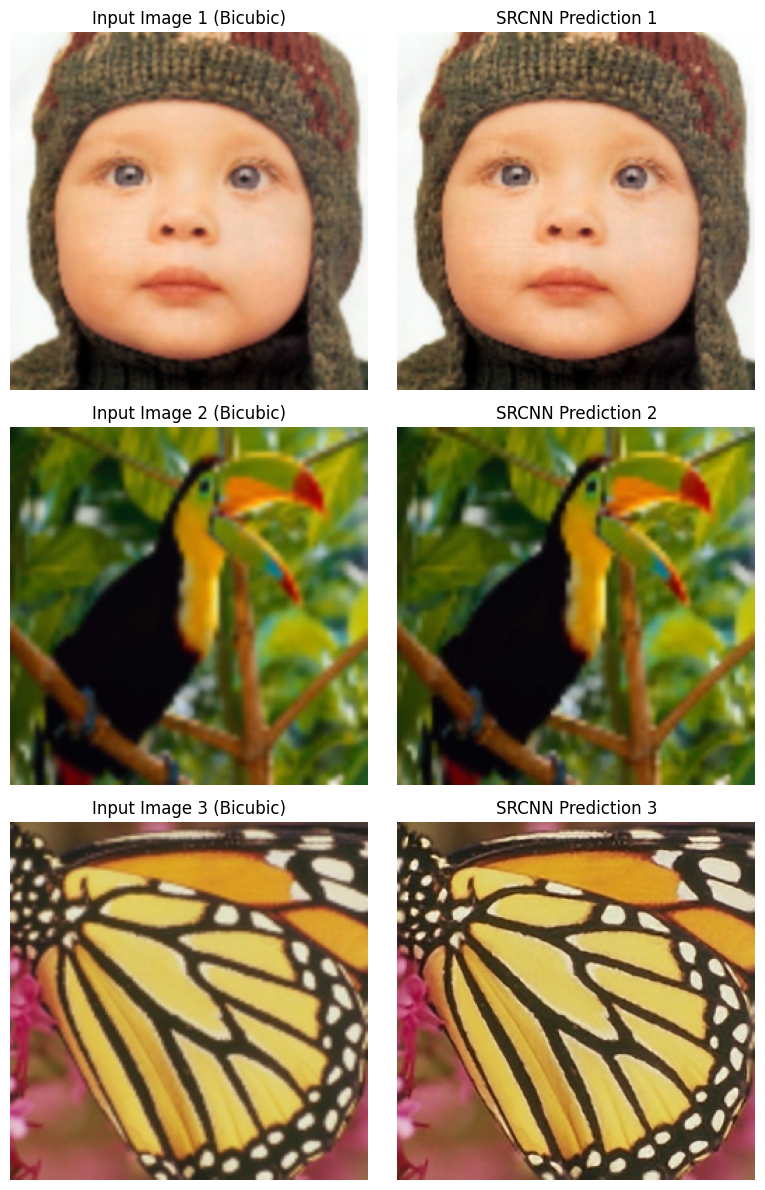

In [52]:
inp1="/content/inp1.jpg"
inp2="/content/inp2.jpg"
inp3="/content/inp3.jpg"
out1="/content/pre1.jpg"
out2="/content/pre2.jpg"
out3="/content/pre3.jpg"

display_comparison_3x3(inp1, inp2, inp3, out1, out2, out3)

In [27]:
!cp /content/SRCNN-keras -r /content/drive/MyDrive

cp: cannot stat '/content/SRCNN-keras': No such file or directory


In [ ]:
from google.colab import drive
drive.mount('/content/drive')